# Kaggle - Santander Product Recommendation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ctypes
import gc
from tqdm import tqdm
import pickle
from scipy import stats
import collections
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Santander product recommendation/train_ver2.csv')
#/content/drive/MyDrive/Santander product recommendation/train_ver2.csv

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/Santander product recommendation/test_ver2.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Optimizing column data types to reduce memory usage 

In [4]:
#This function reduces memory usage of numeric features by changing their data types to the least possible numeric data type.

#https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [5]:
df = reduce_memory_usage(df)

Mem. usage decreased to 2342.72 Mb (53.1% reduction)


In [6]:
df_test = reduce_memory_usage(df_test)

Mem. usage decreased to 122.34 Mb (28.1% reduction)


In [7]:
#Converting date features to datetime format

df['fecha_dato'] = pd.to_datetime(df.fecha_dato)
df['fecha_alta'] = pd.to_datetime(df.fecha_alta)

df_test['fecha_dato'] = pd.to_datetime(df_test.fecha_dato)
df_test['fecha_alta'] = pd.to_datetime(df_test.fecha_alta)

In [8]:
df

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.738281,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.109375,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.539062,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647304,2016-05-28,1166765,N,ES,V,22,2013-08-14,0.0,33,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,0.0,43912.171875,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647305,2016-05-28,1166764,N,ES,V,23,2013-08-14,0.0,33,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,26.0,"RIOJA, LA",0.0,23334.990234,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647306,2016-05-28,1166763,N,ES,H,47,2013-08-14,0.0,33,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647307,2016-05-28,1166789,N,ES,H,22,2013-08-14,0.0,33,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,0.0,199592.812500,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


## Data Cleaning

In [9]:
# Count of null values for each feature
df.isnull().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

Filling NaN values of '**ind_nomina_ult1**' and '**ind_nom_pens_ult1**' with zero

In [10]:
df.fillna(value={'ind_nomina_ult1':0,'ind_nom_pens_ult1':0},inplace=True)

Add new column '**days**' which signifies number of days since customer first joined the bank

In [11]:
df_days_column = (df['fecha_dato'] - df['fecha_alta']).dt.days
df_test_days_column =  (df_test['fecha_dato'] - df_test['fecha_alta']).dt.days

#generate new column 'days' from 
df.insert(loc=6, column='days', value=df_days_column)
df_test.insert(loc=6, column='days', value=df_test_days_column)

#Drop the 'fetch_alta' column
df.drop(columns=['fecha_alta'],inplace = True)
df_test.drop(columns=['fecha_alta'],inplace = True)

column **ult_fec_cli_1t** 

In [12]:
#replace null values with 0 & rest with 1
df['ult_fec_cli_1t'] = df['ult_fec_cli_1t'].apply(lambda x: 1 if pd.notnull(x) else 0)
df_test['ult_fec_cli_1t'] = df_test['ult_fec_cli_1t'].apply(lambda x: 1 if pd.notnull(x) else 0)

column **tipodom**

In [13]:
# remove column tipodom because it has the same value for all customers
df.drop(columns=['tipodom'],inplace = True)
df_test.drop(columns=['tipodom'],inplace = True)

column **cod_prov**

In [14]:
#cod_prov is a duplicate column to nomprov
df.drop(columns=['cod_prov'],inplace = True)
df_test.drop(columns=['cod_prov'],inplace = True)

In [15]:
#converting the ' NA' values to nan
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df_test['age'] = pd.to_numeric(df_test['age'], errors='coerce')

In [16]:
df_test['renta'] = pd.to_numeric(df_test['renta'], errors='coerce')

In [17]:
#converting the ' NA' values to nan
df['antiguedad'] = pd.to_numeric(df['antiguedad'], errors='coerce')
df_test['antiguedad'] = pd.to_numeric(df_test['antiguedad'], errors='coerce')

In [18]:
df.drop(columns=['ind_ahor_fin_ult1', 'ind_aval_fin_ult1'],inplace = True)

In [19]:
#Taking the product columns
target_cols = df.columns.values[22:]
target_cols

array(['ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1'], dtype=object)

In [20]:
# Extracting June 2015 customers who bought new product

prev_month = df[df['fecha_dato'] == '2015-05-28'].set_index(['ncodpers']).iloc[:,21:]
prev_month_customers = df[df['fecha_dato'] == '2015-05-28']['ncodpers'].to_numpy()
next_month = df[(df['fecha_dato'] == '2015-06-28') & (df['ncodpers'].isin(prev_month_customers))].set_index(['ncodpers']).iloc[:,21:]
new_prod = (prev_month - next_month)
q = (new_prod[target_cols] == -1).sum(1)
june_custs = q[q > 0].index

june_new_customers = df[(df['fecha_dato'] == '2015-06-28') & (~df['ncodpers'].isin(prev_month_customers))]

df_sept = df[(df['fecha_dato'] == '2015-06-28') & (df['ncodpers'].isin(june_custs))]

In [21]:
# Converting multi-label dataset into multi-class dataset
import warnings
warnings.filterwarnings('ignore')

train_total = pd.DataFrame()
t=0
for i in tqdm(target_cols):
    train = df_sept[df_sept['ncodpers'].isin(new_prod[new_prod[i] == -1].index)]
    train2 = june_new_customers[june_new_customers[i] == 1]
    train.drop(columns=target_cols,inplace = True)
    train2.drop(columns=target_cols,inplace = True)
    train['target'] = t
    train2['target'] = t

    train = pd.concat([train, train2], ignore_index=True, sort=False)
    train_total = pd.concat([train_total, train], ignore_index=True, sort=False)
    t+=1

del train
del train2
warnings.filterwarnings('default')

100%|██████████| 22/22 [00:00<00:00, 29.76it/s]


## Data Cleaning the new dataset

In [22]:
train_total.isnull().sum()

fecha_dato                   0
ncodpers                     0
ind_empleado                 8
pais_residencia              8
sexo                         8
age                          8
days                         8
ind_nuevo                    8
antiguedad                   8
indrel                       8
ult_fec_cli_1t               0
indrel_1mes                  8
tiprel_1mes                  8
indresi                      8
indext                       8
conyuemp                 45670
canal_entrada               12
indfall                      8
nomprov                    106
ind_actividad_cliente        8
renta                     6193
segmento                     8
target                       0
dtype: int64

In [23]:
# Filling the 'age','days' and 'antiguedad' feature missing values with their mean

train_total.fillna(value={'age':train_total['age'].mean(),'days':train_total['days'].mean(),'antiguedad':train_total['antiguedad'].mean()},inplace=True)
df_test.fillna(value={'age':train_total['age'].mean(),'days':train_total['days'].mean(),'antiguedad':train_total['antiguedad'].mean()},inplace=True)

In [24]:
# This dataset generated from previous EDA that contains cleaned 'renta' feature
file = open('drive/MyDrive/Santander product recommendation/df_group', 'rb')
df_group = pickle.load(file)                     
file.close()

In [25]:
# Generating 5-lag features for every product

#Train lag features
temp1 = df[(df['fecha_dato'] < '2015-06-28') & (df['ncodpers'].isin(train_total['ncodpers']))]
temp1.drop(columns = ['ind_empleado','pais_residencia','sexo','age','days','ind_nuevo','antiguedad','indrel','ult_fec_cli_1t','indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall','nomprov','ind_actividad_cliente','renta','segmento'],inplace = True)

train_lags = {}
for i in tqdm(temp1.itertuples()):
    if i[2] not in train_lags.keys():
        train_lags[i[2]] = []
    train_lags[i[2]].append(np.array(i[3:]).astype(int))


#Test lag features
temp2 = df[(df['fecha_dato'] < '2016-06-28') & (df['fecha_dato'] >= '2016-01-28') & (df['ncodpers'].isin(df_test['ncodpers']))]
temp2.drop(columns = ['ind_empleado','pais_residencia','sexo','age','days','ind_nuevo','antiguedad','indrel','ult_fec_cli_1t','indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall','nomprov','ind_actividad_cliente','renta','segmento'],inplace = True)

test_lags = {}
for i in tqdm(temp2.itertuples()):
    if i[2] not in test_lags.keys():
        test_lags[i[2]] = []
    test_lags[i[2]].append(np.array(i[3:]).astype(int))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
160268it [00:02, 55552.58it/s]
4601406it [01:22, 55540.90it/s]


In [26]:
df_total = pd.concat([train_total, df_test], ignore_index=True, sort=False)
df_total

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,days,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,target
0,2015-06-28,1063241,N,ES,H,41.0,1012.0,0.0,34.0,1.0,0,1,A,S,N,NaN,KFC,N,OURENSE,1.0,108502.562500,02 - PARTICULARES,0.0
1,2015-06-28,1063301,N,ES,H,43.0,1012.0,0.0,34.0,1.0,0,1,I,S,N,NaN,KAT,N,ALICANTE,0.0,150485.406250,02 - PARTICULARES,0.0
2,2015-06-28,1063179,N,ES,V,23.0,1012.0,0.0,34.0,1.0,0,1,A,S,N,NaN,KHE,N,PONTEVEDRA,1.0,96494.640625,03 - UNIVERSITARIO,0.0
3,2015-06-28,1062751,N,ES,V,23.0,1012.0,0.0,34.0,1.0,0,1,A,S,N,NaN,KHE,N,HUELVA,1.0,62948.789062,03 - UNIVERSITARIO,0.0
4,2015-06-28,1063797,N,ES,V,25.0,1011.0,0.0,34.0,1.0,0,1,A,S,N,NaN,KHE,N,MALAGA,1.0,77429.250000,03 - UNIVERSITARIO,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975289,2016-06-28,660237,N,ES,V,55.0,6278.0,0.0,206.0,1.0,0,1,A,S,N,NaN,KAT,N,MADRID,1.0,128643.570000,01 - TOP,NaN
975290,2016-06-28,660238,N,ES,V,30.0,3499.0,0.0,115.0,1.0,0,1,I,S,N,NaN,KFC,N,"RIOJA, LA",0.0,NaN,02 - PARTICULARES,NaN
975291,2016-06-28,660240,N,ES,V,52.0,3499.0,0.0,115.0,1.0,0,1,A,S,N,NaN,KBZ,N,ASTURIAS,1.0,72765.270000,02 - PARTICULARES,NaN
975292,2016-06-28,660243,N,ES,V,32.0,3499.0,0.0,115.0,1.0,0,1,I,S,N,NaN,KFC,N,ASTURIAS,0.0,147488.880000,02 - PARTICULARES,NaN


In [27]:
#Merging the cleaned 'renta' feature to the dataset
df_total.drop(columns = ['renta'],inplace = True)
df_total = pd.DataFrame(df_total.merge(df_group[['ncodpers','renta']], how='inner', on='ncodpers'))

#Rearranging the columns after merging 
cols = df_total.columns.tolist()
cols_new = cols[:-3] + cols[-1:] + cols[-3:-1]
df_total = df_total[cols_new]

In [28]:
#Label encoding the dataset
cols = ['ind_empleado','pais_residencia', 'sexo','ind_nuevo','indrel_1mes','tiprel_1mes', 'indresi', 
        'indext', 'conyuemp', 'canal_entrada','indfall', 'nomprov','segmento','indrel','ind_actividad_cliente']

df_total[cols] = df_total[cols].astype(str).apply(LabelEncoder().fit_transform)

In [29]:
df_total

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,days,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,target
0,2015-06-28,1063241,3,36,0,41.0,1012.0,0,34.0,0,0,0,0,1,0,2,122,0,35,1,108502.562500,1,0.0
1,2016-06-28,1063241,3,36,0,42.0,1378.0,0,45.0,0,0,0,0,1,0,2,122,0,35,1,108502.562500,1,NaN
2,2015-06-28,1063301,3,36,0,43.0,1012.0,0,34.0,0,0,0,1,1,0,2,24,0,2,0,150485.406250,1,0.0
3,2016-06-28,1063301,3,36,0,44.0,1378.0,0,45.0,0,0,0,0,1,0,2,24,0,2,1,150485.406250,1,NaN
4,2015-06-28,1063179,3,36,1,23.0,1012.0,0,34.0,0,0,0,0,1,0,2,150,0,38,1,96494.640625,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975289,2016-06-28,660237,3,36,1,55.0,6278.0,0,206.0,0,0,0,0,1,0,2,24,0,30,1,128643.570312,0,NaN
975290,2016-06-28,660238,3,36,1,30.0,3499.0,0,115.0,0,0,0,1,1,0,2,122,0,39,0,101645.132812,1,NaN
975291,2016-06-28,660240,3,36,1,52.0,3499.0,0,115.0,0,0,0,0,1,0,2,50,0,4,1,72765.273438,1,NaN
975292,2016-06-28,660243,3,36,1,32.0,3499.0,0,115.0,0,0,0,1,1,0,2,122,0,4,0,147488.875000,1,NaN


In [30]:
#Creating the final train dataset
X_train = df_total[~df_total['target'].isnull()]
y_train = X_train['target'].astype(int)
X_train.drop(columns=['target'],inplace = True)

train_cust_ids = X_train['ncodpers']
X_train.drop(columns=['fecha_dato','ncodpers'],inplace = True)

X_train = X_train.values.tolist()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
del df
del train_total
del df_test
del df_group

In [32]:
#Adding the lag variables to the train dataset
k=0
for i in tqdm(train_cust_ids):
    l = train_lags.get(i,[[0]*22])

    try:
        lag_1 = list(l[-1])
    except:
        lag_1 = [0]*22
    try:
        lag_2 = list(l[-2])
    except:
        lag_2 = [0]*22
    try:
        lag_3 = list(l[-3])
    except:
        lag_3 = [0]*22
    try:
        lag_4 = list(l[-4])
    except:
        lag_4 = [0]*22
    try:
        lag_5 = list(l[-5])
    except:
        lag_5 = [0]*22
    
    X_train[k].extend(lag_1+lag_5+lag_4+lag_3+lag_2)
    k+=1  

100%|██████████| 45679/45679 [00:00<00:00, 54361.75it/s]


In [33]:
X_train = np.array(X_train)

In [34]:
##Creating the final test dataset
test_cust_ids = df_total[df_total['target'].isnull()]['ncodpers'].values
X_test = df_total[df_total['target'].isnull()]
X_test.drop(columns=['target'],inplace=True) 
X_test.drop(columns=['fecha_dato','ncodpers'],inplace = True)
X_test = X_test.values.tolist()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
del df_total
del temp1
del temp2

del new_prod
del next_month
del prev_month
del prev_month_customers

In [36]:
X_test_new = []

In [37]:
#Adding the lag variables to the test dataset
k=0
for i in tqdm(test_cust_ids):
    l = test_lags.get(i,[[0]*22])

    try:
        lag_1 = list(l[-1])
    except:
        lag_1 = [0]*22
    try:
        lag_2 = list(l[-2])
    except:
        lag_2 = [0]*22
    try:
        lag_3 = list(l[-3])
    except:
        lag_3 = [0]*22
    try:
        lag_4 = list(l[-4])
    except:
        lag_4 = [0]*22
    try:
        lag_5 = list(l[-5])
    except:
        lag_5 = [0]*22
    
    X_test_new.append(np.array(X_test[k] + lag_1 + lag_5 + lag_4 +lag_3 + lag_2))
    k+=1

100%|██████████| 929615/929615 [00:41<00:00, 22503.05it/s]


In [38]:
X_test = X_test_new

In [39]:
del X_test_new

## Hyper Parameter Tuning XgBoost

In [40]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

params = {'learning_rate':[0.01,0.03,0.1,0.2],
          'max_depth':[3, 5, 8],
          'n_estimators':[10,50],
          'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
          'subsample':[0.5,0.6,0.7,0.8,0.9,1],
          'min_child_weight': `[1,3,5,7,10,14]}

clf = RandomizedSearchCV(XGBClassifier(objective = 'multi:softprob',eval_metric = 'mlogloss'), params, cv=3,scoring='roc_auc_ovo',return_train_score=True, n_jobs = -1,verbose = 10,error_score="raise",n_iter = 15)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBClassifier(eval_metric='mlogloss',
                                           objective='multi:softprob',
                                           predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'learning_rate': [0.01, 0.03, 0.1, 0.2],
                                        'max_depth': [3, 5, 8],
                                        'min_child_weight': [1, 3, 5, 7, 10,
                                                             14],
                                        'n_estimators': [10, 50],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                     

In [ ]:
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 0.9}

In [ ]:
#best hyperparameters
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(objective = 'multi:softprob',eval_metric = 'mlogloss',max_depth=5,n_estimators=50,learning_rate=0.1,colsample_bytree=0.8,subsample=0.9,min_child_weight = 1)
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, eval_metric='mlogloss', max_depth=5,
              n_estimators=50, objective='multi:softprob', subsample=0.9)

In [45]:
y_pred = xgb.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:391: DeprecationWarning: Initializing DMatrix from List is deprecated.
  DeprecationWarning)


In [ ]:
#Finding the new products to be predicted by test users
test_users = {}
for i in tqdm(df[(df['fecha_dato'] == '2016-05-28') & (df['ncodpers'].isin(df_test['ncodpers'].to_numpy()))].iloc):
    test_users[i['ncodpers']] = np.where(i['ind_cco_fin_ult1':'ind_recibo_ult1'] == 0)[0]

## Getting top 7 products for Final Predictions

In [47]:
test_user_ratings = {}
k=0
for i in tqdm(test_cust_ids):
    test_user_ratings[i] = y_pred[k][test_users[i]]
    k+=1

final_preds = []
test_ids = []
for i in tqdm(test_user_ratings.keys()):
    top_seven = test_users[i][np.argsort(test_user_ratings[i])[::-1][:7]]
    final_preds.append(" ".join(target_cols[top_seven]))
    test_ids.append(i)

100%|██████████| 929615/929615 [00:09<00:00, 99290.41it/s]


## Final Submission file

In [48]:
xgb_submission = pd.DataFrame({'ncodpers':test_ids, 'added_products':final_preds})
xgb_submission = xgb_submission.sort_values('ncodpers')
xgb_submission.to_csv('drive/MyDrive/Santander product recommendation/submit67.csv', index=False)

In [49]:
xgb_submission

,ncodpers,added_products
36019,15889,ind_recibo_ult1 ind_reca_fin_ult1 ind_nom_pens...
631716,15890,ind_reca_fin_ult1 ind_cco_fin_ult1 ind_dela_fi...
4338,15892,ind_nom_pens_ult1 ind_nomina_ult1 ind_cno_fin_...
631717,15893,ind_recibo_ult1 ind_nom_pens_ult1 ind_tjcr_fin...
631718,15894,ind_cno_fin_ult1 ind_dela_fin_ult1 ind_ctop_fi...
...,...,...
335929,1553685,ind_cco_fin_ult1 ind_nom_pens_ult1 ind_nomina_...
335931,1553686,ind_cco_fin_ult1 ind_nom_pens_ult1 ind_nomina_...
335932,1553687,ind_cco_fin_ult1 ind_nom_pens_ult1 ind_nomina_...
335933,1553688,ind_cco_fin_ult1 ind_nom_pens_ult1 ind_recibo_...


## Scores 

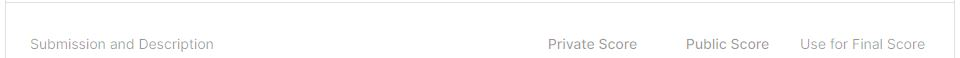

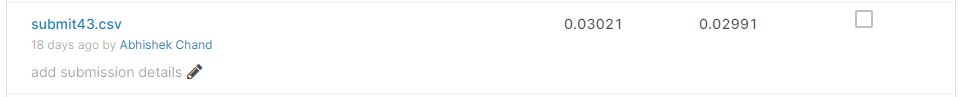